# Houston Health Food Related Venue Locations

### Introduction

The Business Problem: One of the biggest challenges for any restaurant is finding the right location. As they say in Real Estate, the three most important things are location, location, location. This would be especially true for healthy food alternatives to fast food that are more of a niche product with a more limited clientelle than traditional fast food. The Business Problem I will be solving is to identify high-potential areas in Houston for opening healthy food alternatives to fast food.

Who would be interested: The hypothetical interested party would be an investor looking to open a restaurant that is a healthy food alternative to fast food.

### Data Sources and Uses

I will use Starbuck locations in the Houston area from FourSquare as starting point because Starbucks create traffic, Starbucks corporate picks good locations for their stores, and Starbucks clientele are affluent, health conscious and ecologically aware (from the [Motley Fool 6/27/2018](https://www.fool.com/investing/2016/06/16/who-is-starbucks-favorite-customer.aspx) ).

I will use the Neighborhood GIS data from Houston [MyCity web site](https://cohgis-mycity.opendata.arcgis.com/datasets/coh-super-neighborhoods) combined with Starbucks data to determine high potential Neighborhoods.

I will use this FourSquare web page of 
[Venue Categories](https://developer.foursquare.com/docs/build-with-foursquare/categories/):  
Juice Bar  
4bf58dd8d48988d112941735  
Health Food Store  
50aa9e744b90af0d42d5de0e  
Poke Place  
5bae9231bedf3950379f89d4  
Smoothie Shop  
52f2ab2ebcbc57f1066b8b41  
Vegetarian / Vegan Restaurant  
4bf58dd8d48988d1d3941735  

I will use this FourSquare web page of 
[Chain Codes](https://developer.foursquare.com/docs/build-with-foursquare/chains/):    
Starbucks  	556f676fbd6a75a99038d8ec

I will then determine for those Starbucks locations in high potential Houston neighborhoods the availability of health food related venues near them from FourSquare. The lower the availability of health food related venues near a Starbucks, the higher the potential for a new Health food venue in that area. I will then cluster areas by proximity to other Starbucks and away from Health venues to identify high opportunity areas.

### Methodlogy

#### Import the required packages

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
#!pip install seaborn
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,PolynomialFeatures
from sklearn.linear_model import LinearRegression
%matplotlib inline

from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

In [2]:
import numpy as np # library to handle data in a vectorized manner
import io
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import urllib.request, json # library to handle JSON files


import geocoder
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
#from sklearn.cluster import KMeans

import folium # map rendering library

import time

print('Libraries imported.')

Libraries imported.


#### Get cleaned and filtered census and Land Use tract data that was downloaded from MyHouston site. Load geojson tract data for mapping from MyHouston site. 

Census Tract demographics and geo data for all of Houston and filtered to limit to just the Houston Inner Loop, and Land Use data is a 2 gigabyte file that was downloaded with 1.6 million records and filtered to be in just the inner loop. Then the over 180,000 land uses were located within specific census tracts and summarized for total acres by use type by census tract. The result was saved as a csv file. In the interest of saving hours of processing time, the final result is loaded in this notebook.

In [31]:
#load cleaned and filtered tract data from json file on Github
hctILurl='https://raw.githubusercontent.com/gboulger/Coursera_Capstone/master/dfhctIL0610.json'
houston_hctdata=urllib.request.urlopen(hctILurl).read().decode()
hctdict = json.loads(houston_hctdata)
dfhctIL=pd.DataFrame.from_dict(hctdict)
dfhctIL.head()

,level_0,index,type,properties.OBJECTID_1,properties.OBJECTID,properties.TRACT,properties.SUM_POP100,properties.SUM_TotPop,properties.SUM_TotHou,properties.BG_ID,properties.Median_HHI,properties.Shapearea,properties.Shapelen,geometry.type,geometry.coordinates,polygonminmax,polygon,ptlat,ptlng
0,13,13,Feature,430,430,311600,1287,1287,447,482013116001,22473.0,5.565127e+05,3495.309939,Polygon,"[[[-95.2884869798, 29.7025091881], [-95.287639...","[-95.2891309799, -95.2858639794, 29.7024751881...",None,29.702509,-95.288487
1,20,20,Feature,493,493,314001,668,668,402,482013140012,22473.0,1.299971e+06,4775.752457,Polygon,"[[[-95.3899330057, 29.6903061824], [-95.389682...","[-95.3944280067, -95.3894700058, 29.688806182,...",None,29.690306,-95.389933
2,22,22,Feature,495,495,314002,1493,1493,903,482013140021,37198.0,1.464862e+06,5030.578147,Polygon,"[[[-95.3973800068, 29.6853001809], [-95.397069...","[-95.4000420076, -95.3950350064, 29.6852801808...",None,29.685300,-95.397380
3,25,25,Feature,431,431,311600,2185,2185,839,482013116002,28029.0,9.079451e+05,5440.916067,Polygon,"[[[-95.2858679791, 29.7023291878], [-95.286894...","[-95.2897499803, -95.2836189786, 29.7004001875...",None,29.702329,-95.285868
4,31,31,Feature,389,389,310300,608,608,241,482013103006,47254.0,1.932625e+06,5927.401967,Polygon,"[[[-95.3385809945, 29.7406211943], [-95.338316...","[-95.3426939953, -95.3363009942, 29.7399301935...",None,29.740621,-95.338581


In [33]:
#load cleaned and filtered land use data from csv file on Github
url='https://raw.githubusercontent.com/gboulger/Coursera_Capstone/master/hctwLUacer0609.csv'
dfhctacer=pd.read_csv(url)
print('file loaded')

file loaded


In [34]:
dfhctacer.head()

,HCT,AGRICULTURE,COMMERCIAL,INDUSTRIAL,MULTIFAM,OFFICE,PARKS,PubInst,SINGLEFAM,TRANS,UNDEVELOPED,COInst,%COInst,Grand Total,SB Cnt,HHI,Pop,Sbyn
0,100000,0.0,150.0,7.0,27.0,93.0,NaN,101.0,1.0,23.0,129,345,0.649,532,21,53782,4690,Yes
1,210100,0.0,2.0,17.0,2.0,2.0,4,13.0,1.0,1.0,55,17,0.177,97,0,87375,9652,No
2,210400,NaN,20.0,44.0,3.0,4.0,1,2.0,130.0,NaN,119,26,0.081,324,0,24786,5328,No
3,210500,NaN,36.0,39.0,21.0,1.0,NaN,19.0,170.0,1.0,70,57,0.158,357,0,29263,4882,No
4,210600,0.0,13.0,18.0,6.0,0.0,0,4.0,155.0,1.0,23,18,0.079,222,0,42015,5497,No


In [32]:
#load geojson data for mapping from the MyHouston web site
hctILurl='https://opendata.arcgis.com/datasets/35ef9379a9fd491aab08cb63aa33893e_5.geojson'
houston_hctdata2=urllib.request.urlopen(hctILurl).read().decode()

#### Get Starbucks and Health Food venue data from FourSquare

Starbucks in the inner loop area. Where the queries were limited to 50 venues, it was necessary to break the inner loop into 4 quadrants to get all available Starbucks locations. 

In [4]:
CLIENT_ID = '1XQSXUYL0XRAA4CDKKBTGPOD4PBG0XCORNW3UEVSEWDBZBOM' # your Foursquare ID
CLIENT_SECRET = 'KT4SY45YAPNQO2KS4TEZQTGWNUKWBZS5KOO1DXEED1YS54ND' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

In [5]:
address = 'Houston, TX'

geolocator = Nominatim(user_agent="tx_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Houston are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Houston are 29.7589382, -95.3676974.


In [6]:
# FourSquare limits results to 50 and there are more Starbucks in Houston than 50
# so we will break Houston int 4 qudrants with the NE and SW corners below
ne1='29.8282854, -95.3676974'
sw1='29.7589382, -95.446599'
ne2='29.8282854, -95.2887958'
sw2='29.7589382, -95.3676974'
ne3= '29.7589382, -95.3676974'
sw3= '29.689591, -95.446599'
ne4= '29.7589382, -95.2887958'
sw4= '29.689591, -95.3676974'

In [7]:
LIMIT = 200 # limit of number of venues returned by Foursquare API
radius = 16000 # define radius

# create URL for quadrants 1-4
url1 = 'https://api.foursquare.com/v2/venues/search?& &query=Starbucks&intent=browse&client_id={}&client_secret={}&v={}&ne={}&sw={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    ne1, 
    sw1, 
    LIMIT)
url2 = 'https://api.foursquare.com/v2/venues/search?& &query=Starbucks&intent=browse&client_id={}&client_secret={}&v={}&ne={}&sw={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    ne2, 
    sw2, 
    LIMIT)
url3 = 'https://api.foursquare.com/v2/venues/search?& &query=Starbucks&intent=browse&client_id={}&client_secret={}&v={}&ne={}&sw={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    ne3, 
    sw3, 
    LIMIT)
url4 = 'https://api.foursquare.com/v2/venues/search?& &query=Starbucks&intent=browse&client_id={}&client_secret={}&v={}&ne={}&sw={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    ne4, 
    sw4, 
    LIMIT)

In [8]:
results1 = requests.get(url1).json()
results2 = requests.get(url2).json()
results3 = requests.get(url3).json()
results4 = requests.get(url4).json()

In [9]:
venues1 = results1['response']['venues']
nearby_venues1 = json_normalize(venues1) # flatten JSON
venues2 = results2['response']['venues']
nearby_venues2 = json_normalize(venues2) # flatten JSON
venues3 = results3['response']['venues']
nearby_venues3 = json_normalize(venues3) # flatten JSON
venues4 = results4['response']['venues']
nearby_venues4 = json_normalize(venues4) # flatten JSON

<ipython-input-9-39dc3cdd2f2f>:2: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  nearby_venues1 = json_normalize(venues1) # flatten JSON
<ipython-input-9-39dc3cdd2f2f>:4: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  nearby_venues2 = json_normalize(venues2) # flatten JSON
<ipython-input-9-39dc3cdd2f2f>:6: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  nearby_venues3 = json_normalize(venues3) # flatten JSON
<ipython-input-9-39dc3cdd2f2f>:8: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  nearby_venues4 = json_normalize(venues4) # flatten JSON


In [10]:
dfsb=nearby_venues1[['name', 'location.address', 'location.lat', 'location.lng']]
dfsb2=nearby_venues2[['name', 'location.address', 'location.lat', 'location.lng']]
dfsb3=nearby_venues3[['name', 'location.address', 'location.lat', 'location.lng']]
dfsb4=nearby_venues4[['name', 'location.address', 'location.lat', 'location.lng']]

In [11]:
dfsb=dfsb.append(dfsb2)
dfsb=dfsb.append(dfsb3)
dfsb=dfsb.append(dfsb4)
dfsb.shape

(79, 4)

In [12]:
# add columns to hold Super Neighborhood (SNB) 
#and Houston Census Tract (HCT) info

dfsb['HCT']=pd.Series()

<ipython-input-12-693b2c81bd5d>:4: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  dfsb['HCT']=pd.Series()


In [13]:
dfsb.reset_index(inplace=True)

In [14]:
dfsb.head()

,index,name,location.address,location.lat,location.lng,HCT
0,0,Starbucks,1035 N Shepherd Dr,29.789356,-95.410975,NaN
1,1,Starbucks,445 North Loop W,29.812380,-95.405550,NaN
2,2,Starbucks,1801 Durham,29.776571,-95.410880,NaN
3,3,Starbucks,5535 Memorial Dr,29.761209,-95.417456,NaN
4,4,Starbucks,2919 Allen Pkwy,29.759791,-95.395788,NaN


Health Food venues in the inner loop area. Queries were run for Smoothies and Juice and all other Health Food related queries were found to be redundant with those two.

In [15]:
# create URL for Smoothie
url1 = 'https://api.foursquare.com/v2/venues/search?& &query=Smoothie&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, 
    longitude, 
    radius, 
    LIMIT)

# create URL for Juice
url2 = 'https://api.foursquare.com/v2/venues/search?& &query=Juice&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, 
    longitude, 
    radius, 
    LIMIT)

In [16]:
results1 = requests.get(url1).json()
results2 = requests.get(url2).json()

In [17]:
venues1 = results1['response']['venues']
nearby_venues1 = json_normalize(venues1) # flatten JSON
venues2 = results2['response']['venues']
nearby_venues2 = json_normalize(venues2) # flatten JSON

<ipython-input-17-ffaccb93eed4>:2: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  nearby_venues1 = json_normalize(venues1) # flatten JSON
<ipython-input-17-ffaccb93eed4>:4: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  nearby_venues2 = json_normalize(venues2) # flatten JSON


In [67]:
dfhf=nearby_venues1[['name', 'location.address', 'location.lat', 'location.lng']]

In [68]:
dfhf2=dfhf.append(nearby_venues2[['name', 'location.address', 'location.lat', 'location.lng']], ignore_index=True)

In [69]:
dfhf2.shape

(100, 4)

In [70]:
# add columns to hold Super Neighborhood (SNB) 
#and Houston Census Tract (HCT) info

dfhf2['HCT']=pd.Series()

<ipython-input-70-fd1267c9a229>:4: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  dfhf2['HCT']=pd.Series()


In [71]:
dfhf2.head()

,name,location.address,location.lat,location.lng,HCT
0,Smoothie Factory,"815 Walker St., Suite T 06",29.758618,-95.365505,NaN
1,Tropical Smoothie Cafe,700 Milam St,29.760100,-95.365200,NaN
2,Smoothie King - Temporarily Closed,1 Main St.,29.766276,-95.358947,NaN
3,Smoothie King,913 Westheimer Rd,29.744462,-95.390984,NaN
4,Smoothie Factory,930 Main St Ste T210,29.757358,-95.365271,NaN


#### Determine which census tract each venue is in

In [23]:
# Define a class for determining if a shape is in a polygon
class Point:
    def __init__(self, x, y):
        """
        A point specified by (x,y) coordinates in the cartesian plane
        """
        self.x = x
        self.y = y

class Polygon:
    def __init__(self, points):
        """
        points: a list of Points in clockwise order.
        """
        self.points = points
        
    @property
    def edges(self):
        ''' Returns a list of tuples that each contain 2 points of an edge '''
        edge_list = []
        for i,p in enumerate(self.points):
            p1 = p
            p2 = self.points[(i+1) % len(self.points)]
            edge_list.append((p1,p2))

        return edge_list

In [24]:
# define a function to determine if a point is in a polygon
def contains(self, point):
        import sys
        # _huge is used to act as infinity if we divide by 0
        _huge = sys.float_info.max
        # _eps is used to make sure points are not on the same line as vertexes
        _eps = 0.00001
        
         
        # We start on the outside of the polygon
        inside = False
        for edge in self.edges:
            # Make sure A is the lower point of the edge
            # use absolute value for long since its negative
            A=Point(abs(edge[0][0]), edge[0][1])
            B=Point(abs(edge[1][0]), edge[1][1])
            #A, B = edge[0], edge[1]
            if A.y > B.y:
                A, B = B, A
            
            # Make sure point is not at same height as vertex
            if point.y == A.y or point.y == B.y:
                point.y += _eps

            if (point.y > B.y or point.y < A.y or abs(point.x) > max(A.x, B.x)):
                # The horizontal ray does not intersect with the edge
                continue

            if abs(point.x) < min(A.x, B.x): # The ray intersects with the edge inside = not inside continue try: m_edge = (B.y - A.y) / (B.x - A.x) except ZeroDivisionError: m_edge = _huge try: m_point = (point.y - A.y) / (point.x - A.x) except ZeroDivisionError: m_point = _huge if m_point >= m_edge:
                # The ray intersects with the edge
                inside = not inside
                continue

        return inside

In [25]:
j=0
dfsb['location.lng'][1]

-95.40555

In [26]:
# For each Starbucks venue determine which tract it is in
linecount=0
starttime=time.time()
stopj=dfsb.shape[0]
#stopj=200
for j in range(0, stopj):
    p1=Point(float(dfsb['location.lng'][j]), float(dfsb['location.lat'][j]))
    status1=False
    print('---'+str(j)+'---', end='\r', flush=True)
    linecount=0
    for i in range(dfhctIL.shape[0]):
        if status1 == False: #and dfhct['geometry.type'][linecount]=='Polygon':
            if (dfhctIL['polygonminmax'][i][0] < p1.x < dfhctIL['polygonminmax'][i][1]) and (dfhctIL['polygonminmax'][i][2] < p1.y < dfhctIL['polygonminmax'][i][3]):
                #print(i) #, end='\r', flush=True)
                if len(dfhctIL.iloc[i,14][0])>0:
                    poly2=dfhctIL.iloc[i,14][0]
                    q=Polygon(poly2)
                    status1=contains(q, p1)
                    #linecount=linecount+1
                    if status1==True:
                        dfsb['HCT'][j]=str(int(dfhctIL['properties.TRACT'][i]))
                        #status1=True
                        #print(dfhctIL['properties.TRACT'][i])
                if len(dfhctIL.iloc[i,14][0])==2 and status1==False:
                    poly2=dfhctIL.iloc[i,14][1]
                    q=Polygon(poly2)
                    status1=contains(q, p1)
                    #linecount=linecount+1
                    if status1==True:
                        dfsb['HCT'][j]=str(int(dfhctIL['properties.TRACT'][i]))
                        #status1=True
                        #print(dfhctIL['properties.TRACT'][i])
            linecount=linecount+1
        else:

            linecount=linecount+1
        #print(linecount, end='\r', flush=True)
endtime=time.time()
elapsedtime=endtime-starttime
#print(elapsedtime)

<ipython-input-26-be1faef99b3c>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfsb['HCT'][j]=str(int(dfhctIL['properties.TRACT'][i]))


In [27]:
# We can see that some tracts weren't found
dfsb

,index,name,location.address,location.lat,location.lng,HCT
0,0,Starbucks,1035 N Shepherd Dr,29.789356,-95.410975,510900.0
1,1,Starbucks,445 North Loop W,29.812380,-95.405550,NaN
2,2,Starbucks,1801 Durham,29.776571,-95.410880,510600.0
3,3,Starbucks,5535 Memorial Dr,29.761209,-95.417456,510800.0
4,4,Starbucks,2919 Allen Pkwy,29.759791,-95.395788,410200.0
5,5,Starbucks,1440 Studemont St,29.773367,-95.389812,510200.0
6,6,Starbucks,2580 Shearn St,29.774603,-95.384960,510200.0
7,7,Starbucks,217 Heights Blvd,29.774777,-95.398343,510600.0
8,8,Starbucks,3017 N. Durham Drive,29.814732,-95.411029,NaN
9,9,Starbucks,6201 Washington Ave,29.772608,-95.424679,510800.0


In [29]:
# drop records that were not in inner loop tracts
dfsb = dfsb[dfsb['HCT'].notna()]
dfsb

,index,name,location.address,location.lat,location.lng,HCT
0,0,Starbucks,1035 N Shepherd Dr,29.789356,-95.410975,510900.0
2,2,Starbucks,1801 Durham,29.776571,-95.410880,510600.0
3,3,Starbucks,5535 Memorial Dr,29.761209,-95.417456,510800.0
4,4,Starbucks,2919 Allen Pkwy,29.759791,-95.395788,410200.0
5,5,Starbucks,1440 Studemont St,29.773367,-95.389812,510200.0
6,6,Starbucks,2580 Shearn St,29.774603,-95.384960,510200.0
7,7,Starbucks,217 Heights Blvd,29.774777,-95.398343,510600.0
9,9,Starbucks,6201 Washington Ave,29.772608,-95.424679,510800.0
11,11,Starbucks,Tbd,29.761496,-95.372090,100000.0
12,12,The Bel Air,2121 Allen Pkwy,29.760030,-95.390517,410200.0


In [72]:
# For each Health Food venue determine which tract it is in
linecount=0
starttime=time.time()
stopj=dfhf2.shape[0]
#stopj=200
for j in range(0, stopj):
    p1=Point(float(dfhf2['location.lng'][j]), float(dfhf2['location.lat'][j]))
    status1=False
    print('---'+str(j)+'---', end='\r', flush=True)
    linecount=0
    for i in range(dfhctIL.shape[0]):
        if status1 == False: #and dfhct['geometry.type'][linecount]=='Polygon':
            if (dfhctIL['polygonminmax'][i][0] < p1.x < dfhctIL['polygonminmax'][i][1]) and (dfhctIL['polygonminmax'][i][2] < p1.y < dfhctIL['polygonminmax'][i][3]):
                #print(i) #, end='\r', flush=True)
                if len(dfhctIL.iloc[i,14][0])>0:
                    poly2=dfhctIL.iloc[i,14][0]
                    q=Polygon(poly2)
                    status1=contains(q, p1)
                    #linecount=linecount+1
                    if status1==True:
                        dfhf2['HCT'][j]=str(int(dfhctIL['properties.TRACT'][i]))
                        #status1=True
                        #print(dfhctIL['properties.TRACT'][i])
                if len(dfhctIL.iloc[i,14][0])==2 and status1==False:
                    poly2=dfhctIL.iloc[i,14][1]
                    q=Polygon(poly2)
                    status1=contains(q, p1)
                    #linecount=linecount+1
                    if status1==True:
                        dfhf2['HCT'][j]=str(int(dfhctIL['properties.TRACT'][i]))
                        #status1=True
                        #print(dfhctIL['properties.TRACT'][i])
            linecount=linecount+1
        else:

            linecount=linecount+1
        #print(linecount, end='\r', flush=True)
endtime=time.time()
elapsedtime=endtime-starttime
#print(elapsedtime)

<ipython-input-72-9f1f369cc4d7>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfhf2['HCT'][j]=str(int(dfhctIL['properties.TRACT'][i]))


In [73]:
dfhf2

,name,location.address,location.lat,location.lng,HCT
0,Smoothie Factory,"815 Walker St., Suite T 06",29.758618,-95.365505,100000.0
1,Tropical Smoothie Cafe,700 Milam St,29.760100,-95.365200,100000.0
2,Smoothie King - Temporarily Closed,1 Main St.,29.766276,-95.358947,100000.0
3,Smoothie King,913 Westheimer Rd,29.744462,-95.390984,410701.0
4,Smoothie Factory,930 Main St Ste T210,29.757358,-95.365271,100000.0
5,Smoothie King,"5535 Memorial Drive, Suite E",29.760826,-95.417346,510800.0
6,Smoothie King,1001 Fannin St.,29.755796,-95.363921,100000.0
7,Planet Smoothie,1200 McKinney St,29.754501,-95.365559,100000.0
8,Smoothie King,1923 Taylor St,29.775785,-95.382698,510200.0
9,Smoothie King,5410 Kirby Dr,29.723330,-95.418804,NaN


In [74]:
# drop records that were not in inner loop tracts
dfhf2 = dfhf2[dfhf2['HCT'].notna()]
dfhf2

,name,location.address,location.lat,location.lng,HCT
0,Smoothie Factory,"815 Walker St., Suite T 06",29.758618,-95.365505,100000.0
1,Tropical Smoothie Cafe,700 Milam St,29.760100,-95.365200,100000.0
2,Smoothie King - Temporarily Closed,1 Main St.,29.766276,-95.358947,100000.0
3,Smoothie King,913 Westheimer Rd,29.744462,-95.390984,410701.0
4,Smoothie Factory,930 Main St Ste T210,29.757358,-95.365271,100000.0
5,Smoothie King,"5535 Memorial Drive, Suite E",29.760826,-95.417346,510800.0
6,Smoothie King,1001 Fannin St.,29.755796,-95.363921,100000.0
7,Planet Smoothie,1200 McKinney St,29.754501,-95.365559,100000.0
8,Smoothie King,1923 Taylor St,29.775785,-95.382698,510200.0
10,Smoothie King,2617- D W. Holcombe Blvd.,29.705566,-95.419244,413202.0


In [ ]:
#### Map the Starbucks and Healthfood venues on a choropleth map of HHI by tract
map_houston = folium.Map(location=[latitude, longitude], zoom_start=12)

# Create HHI by tract overlay
map_houston.choropleth(
    geo_data=houston_hctdata2,
    data=dfhhiIL,
    columns=['properties.TRACT', 'properties.Median_HHI'],
    key_on='feature.properties.TRACT',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Income by Census Tract'
    )

# add Starbucks markers to map
for lat, lng, label in zip(dfsb['location.lat'], dfsb['location.lng'], dfsb['location.address']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=2,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_houston)  
    
# add Health Food venue markers to map
for lat, lng, label in zip(dfhf2['location.lat'], dfhf2['location.lng'], dfhf2['name']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=2,
        popup=label,
        color='green',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_houston)  
    
map_houston

### Modeling

#### Exploratory Data Analysis

Relationship between Starbucks and Household Income
A topline look at the map indicates some correlation between income and a Starbucks location and when we plot whether a tract has a Starbucks, there is a relationship, but the correlation is not very strong:

In [35]:
# Replace NaN with zeros
dfhctacer['OFFICE'].replace(np.nan,0, inplace=True)
dfhctacer['COMMERCIAL'].replace(np.nan,0, inplace=True)
dfhctacer['UNDEVELOPED'].replace(np.nan,0, inplace=True)
dfhctacer['MULTIFAM'].replace(np.nan,0, inplace=True)

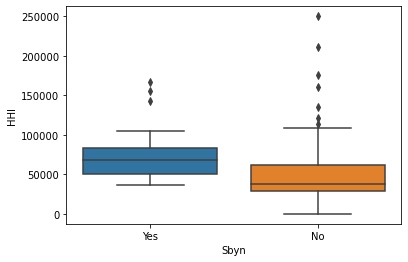

In [36]:
# Boxplot shows that most Starbucks are in tracts with HHI > $50k
sns.boxplot(x="Sbyn", y="HHI", data=dfhctacer)

(0.0, 22.052917988922513)

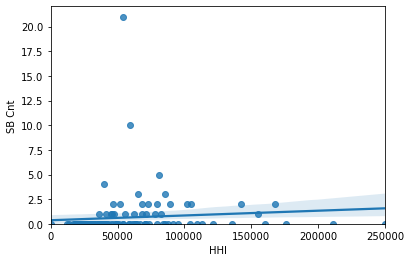

In [37]:
sns.regplot(x="HHI", y="SB Cnt", data=dfhctacer)
plt.ylim(0,)
# We see that # of starbucks is loosely positively correlated with HHI

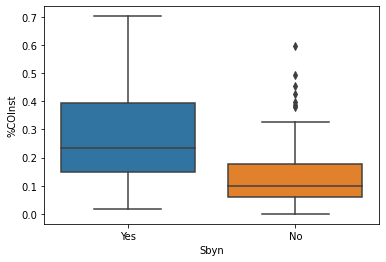

In [38]:
# Most Starbucks are located in tracts that have a higher percentage of Commercial, 
#Office and Institutional
sns.boxplot(x="Sbyn", y="%COInst", data=dfhctacer)

(0.0, 22.12339835340985)

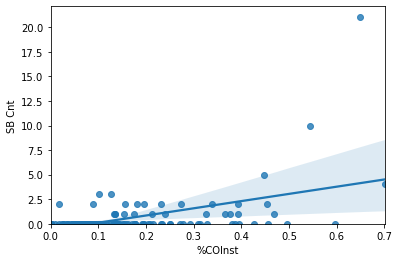

In [39]:
sns.regplot(x="%COInst", y="SB Cnt", data=dfhctacer)
plt.ylim(0,)
# We see that # of starbucks is loosely positively correlated with %COInst

In [40]:
# create a subset df that with HHI > $50,000
dfacerhhi=dfhctacer[dfhctacer['HHI']>50000]
dfacerhhi.head()

,HCT,AGRICULTURE,COMMERCIAL,INDUSTRIAL,MULTIFAM,OFFICE,PARKS,PubInst,SINGLEFAM,TRANS,UNDEVELOPED,COInst,%COInst,Grand Total,SB Cnt,HHI,Pop,Sbyn
0,100000,0.0,150.0,7.0,27.0,93.0,NaN,101.0,1.0,23.0,129,345,0.649,532,21,53782,4690,Yes
1,210100,0.0,2.0,17.0,2.0,2.0,4,13.0,1.0,1.0,55,17,0.177,97,0,87375,9652,No
24,310200,0.0,18.0,97.0,4.0,3.0,1,13.0,50.0,6.0,96,34,0.117,286,0,62778,1463,No
47,312500,1.0,37.0,63.0,12.0,28.0,0,3.0,60.0,3.0,38,68,0.278,245,0,70653,4235,No
48,312600,0.0,26.0,31.0,44.0,16.0,0,25.0,101.0,0.0,38,68,0.239,284,1,68186,5871,Yes


In [41]:
# but if we look at just >$50k tracts, Commercial is strongly correlated
dfacerhhi.corr()['SB Cnt'].sort_values()

HCT           -0.578959
SINGLEFAM     -0.230185
HHI           -0.170480
INDUSTRIAL    -0.032001
AGRICULTURE    0.097685
Pop            0.130236
TRANS          0.180907
MULTIFAM       0.248156
PubInst        0.331916
UNDEVELOPED    0.421111
OFFICE         0.570885
%COInst        0.575434
COMMERCIAL     0.626161
COInst         0.736006
SB Cnt         1.000000
Name: SB Cnt, dtype: float64

#### Modeling

Given the above, a Ridge Regression model was developed using tracts with Household Income greater than $50,000 and tract acreage of Office, Commercial, Undeveloped and MultiFamily. The model had a fairly good correlation of .636 and shows that even for Starbucks, there are tracts with opportunities for new venues.

In [43]:
# Set up test and train samples
features =['OFFICE', 'COMMERCIAL', 'UNDEVELOPED', 'MULTIFAM']    
X = dfacerhhi[features ]
Y = dfacerhhi['SB Cnt']

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.15, random_state=1)


print("number of test samples :", x_test.shape[0])
print("number of training samples:",x_train.shape[0])

number of test samples : 8
number of training samples: 43


In [44]:
#The model has a reasonably good score
RidgeModel=Ridge(alpha=0.1)
RidgeModel.fit(x_train,y_train)
RidgeModel.score(x_train,y_train)

0.6358271239135196

In [45]:
yhat=RidgeModel.predict(x_train)
ytesthat=RidgeModel.predict(x_test)
Y=RidgeModel.predict(X)

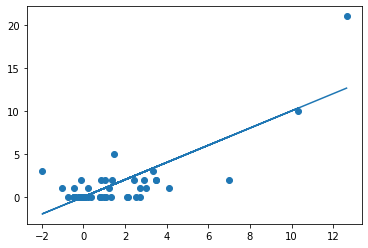

In [46]:
# Model has reasonable agreement
plt.scatter(Y, dfacerhhi['SB Cnt'])
plt.plot(Y,Y)

### Results

The model was run to give a potential score for each tract in the inner loop and then compared to the number of Health Food venues in those tracts, and sorted by the tracts with the highest differential between potential and Health Food venue counts. 

In [47]:
# Rum model for all tracts in inner loop
features =['OFFICE', 'COMMERCIAL', 'UNDEVELOPED', 'MULTIFAM']    
Xtot = dfhctacer[features]
Ytot = RidgeModel.predict(Xtot)

In [48]:
dfhctacer['SBPredicted']=Ytot

In [51]:
# Set predicted values low for all HHI values below $50k
dfhctacer.loc[dfhctacer['HHI'] < 50000, ['SBPredicted']] = -2

In [52]:
dfhctacer.head()

,HCT,AGRICULTURE,COMMERCIAL,INDUSTRIAL,MULTIFAM,OFFICE,PARKS,PubInst,SINGLEFAM,TRANS,UNDEVELOPED,COInst,%COInst,Grand Total,SB Cnt,HHI,Pop,Sbyn,SBPredicted
0,100000,0.0,150.0,7.0,27.0,93.0,NaN,101.0,1.0,23.0,129,345,0.649,532,21,53782,4690,Yes,12.640982
1,210100,0.0,2.0,17.0,2.0,2.0,4,13.0,1.0,1.0,55,17,0.177,97,0,87375,9652,No,-0.013006
2,210400,NaN,20.0,44.0,3.0,4.0,1,2.0,130.0,NaN,119,26,0.081,324,0,24786,5328,No,-2.000000
3,210500,NaN,36.0,39.0,21.0,1.0,NaN,19.0,170.0,1.0,70,57,0.158,357,0,29263,4882,No,-2.000000
4,210600,0.0,13.0,18.0,6.0,0.0,0,4.0,155.0,1.0,23,18,0.079,222,0,42015,5497,No,-2.000000


In [81]:
dfhf2=dfhf2.reset_index()

In [124]:
x=[]
for i in range(dfhf2.shape[0]):
    x.append(int(dfhf2['HCT'][i]))
dfhf2['HCT']=x

In [128]:
dfhfhct=dfhf2.groupby(['HCT']).count()


In [132]:
dfhfhct.head()

,index,name,location.address,location.lat,location.lng,HF Cnt
HCT,,,,,,
100000,11,11,10,11,11,0
210500,1,1,1,1,1,0
312000,1,1,1,1,1,0
312100,1,1,1,1,1,0
312600,1,1,0,1,1,0


In [133]:
# Add Health Food venue counts to dataframe and make adjustmens as necesary
dfhctacer['HF Cnt']=pd.Series()

for i in range(dfhfhct.shape[0]):
    hct=int(dfhfhct.index[i])
    hfcnt=dfhfhct['name'][hct]
    dfhctacer.loc[dfhctacer['HCT'] == hct, ['HF Cnt']] = hfcnt
# Replace NaN with zeros
dfhctacer['HF Cnt'].replace(np.nan,0, inplace=True)
dfhctacer['HF Var']=dfhctacer['SBPredicted']-dfhctacer['HF Cnt']

<ipython-input-133-6035820ab86d>:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  dfhctacer['HF Cnt']=pd.Series()


In [134]:
dfhctacer.head()

,HCT,AGRICULTURE,COMMERCIAL,INDUSTRIAL,MULTIFAM,OFFICE,PARKS,PubInst,SINGLEFAM,TRANS,UNDEVELOPED,COInst,%COInst,Grand Total,SB Cnt,HHI,Pop,Sbyn,SBPredicted,HF Cnt,HF Var
0,100000,0.0,150.0,7.0,27.0,93.0,NaN,101.0,1.0,23.0,129,345,0.649,532,21,53782,4690,Yes,12.640982,11.0,1.640982
1,210100,0.0,2.0,17.0,2.0,2.0,4,13.0,1.0,1.0,55,17,0.177,97,0,87375,9652,No,-0.013006,0.0,-0.013006
2,210400,NaN,20.0,44.0,3.0,4.0,1,2.0,130.0,NaN,119,26,0.081,324,0,24786,5328,No,-2.000000,0.0,-2.000000
3,210500,NaN,36.0,39.0,21.0,1.0,NaN,19.0,170.0,1.0,70,57,0.158,357,0,29263,4882,No,-2.000000,1.0,-3.000000
4,210600,0.0,13.0,18.0,6.0,0.0,0,4.0,155.0,1.0,23,18,0.079,222,0,42015,5497,No,-2.000000,0.0,-2.000000


In [135]:
# Show top 10 results for Health Food venue potential var with count (HF Var)
results=dfhctacer[['HCT', 'SBPredicted', 'HF Cnt', 'HF Var']]
results.sort_values(by='HF Var', ascending=False, inplace=True)
results.head(10)

<ipython-input-135-556f16f8001e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results.sort_values(by='HF Var', ascending=False, inplace=True)


,HCT,SBPredicted,HF Cnt,HF Var
53,313100,10.297648,2.0,8.297648
89,411800,6.976731,2.0,4.976731
87,411502,4.107090,0.0,4.107090
47,312500,2.740413,0.0,2.740413
81,411000,2.701852,0.0,2.701852
111,510900,3.338934,1.0,2.338934
84,411300,2.135443,0.0,2.135443
114,511100,2.114070,0.0,2.114070
0,100000,12.640982,11.0,1.640982
108,510600,3.506404,2.0,1.506404


#### Map the results

In [ ]:
# Map Health Food venues on a choropleth of tract potentials

map_houston = folium.Map(location=[latitude, longitude], zoom_start=12)

# Create HHI by tract overlay
map_houston.choropleth(
    geo_data=houston_hctdata2,
    data=dfhctacer,
    columns=['HCT', 'SBPredicted'],
    key_on='feature.properties.TRACT',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Income by Census Tract'
    )

# add Starbucks markers to map
for lat, lng, label in zip(dfsb['location.lat'], dfsb['location.lng'], dfsb['location.address']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=2,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_houston)  
    
# add Health Food venue markers to map
for lat, lng, label in zip(dfhf2['location.lat'], dfhf2['location.lng'], dfhf2['name']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=2,
        popup=label,
        color='green',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_houston)  
    
map_houston

### Conclusion

This study analyzed the locations of Starbucks venues in census tracts in the inner loop of Houston to develop a predictive model that would be useful for selecting locations for a new Health Food restaurant and was able to identify numerous census tracts that have high potential.